<a href="https://colab.research.google.com/github/AnIsAsPe/Prediccion-produccion-electricidad/blob/main/notebooks/Predicci%C3%B3n_producci%C3%B3n_electricidad_Feb22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [2]:
import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


# Funciones

In [3]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')


# Lectura de datos

In [39]:
file = 'https://raw.githubusercontent.com/AnIsAsPe/Prediccion-produccion-electricidad/main/Datos/IPG2211A2N_202207.csv'

datos = pd.read_csv(file, index_col = [0], parse_dates=['DATE'])
datos = datos.loc['2000-01-01':]
datos.columns = ['Producción']  # NAICS 2211

datos

,Producción
DATE,
2000-01-01,100.9623
2000-02-01,93.1065
2000-03-01,87.0234
2000-04-01,80.4433
2000-05-01,83.4549
...,...
2022-03-01,102.7847
2022-04-01,91.4572
2022-05-01,93.8530


In [5]:
# revisamos si las fechas están ordenads
datos.index.is_monotonic

True

In [6]:
datos.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='DATE', length=271, freq=None)

In [7]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
datos.index.freq = datos.index.inferred_freq
datos.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='DATE', length=271, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

# Exploración y Visualización de la Serie Temporal

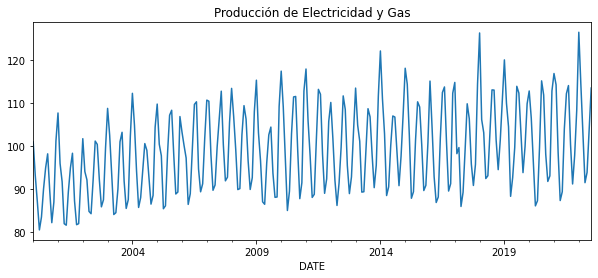

In [8]:
datos['Producción'].plot(figsize=(10,4), title='Producción de Electricidad y Gas')
plt.show()

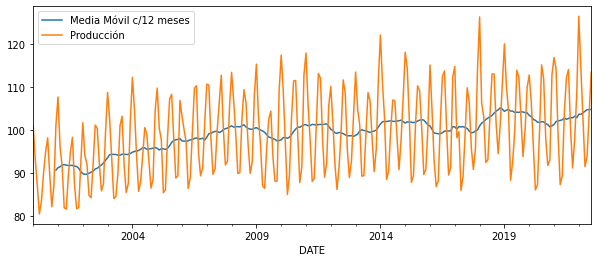

In [9]:
datos['Producción'].rolling(12).mean().plot(figsize=(10,4),label='Media Móvil c/12 meses')
datos['Producción'].plot()
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

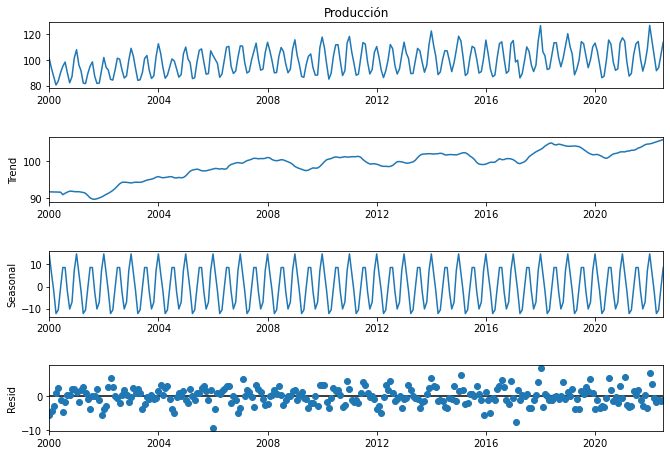

In [12]:
decomp = seasonal_decompose(datos['Producción']
                            , period=12, extrapolate_trend='freq'
                            )
fig =decomp.plot()
fig.set_size_inches(10,7)

# Convertir los datos a Estacionarios

Realizamos el **test Dickey-Fuller** en la cual, **la hipótesis nula es que los datos no son estacionarios** (*si p es muy pequeña, rechazaremos la hipotesis nula*)
La hipotesis alternativa es que son estacionarios

In [13]:
pValue = adfuller(datos['Producción'])[1]
pValue

0.41398340161359953

In [14]:
p_value_adfuller(datos['Producción'])

P-value:  0.41398340161359953
No se rechaza la hipóteis nula, los datos no son estacionarios


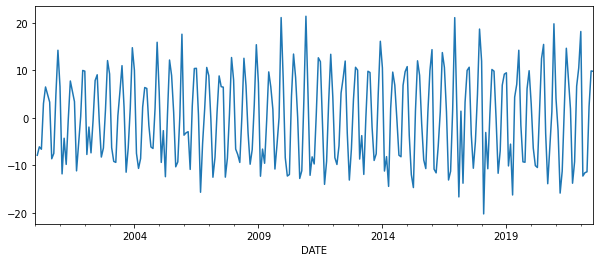

In [20]:
datos['1a diff']= datos['Producción'] - datos['Producción'].shift(1)  
datos['1a diff'].plot(figsize=(10,4))
plt.show()

In [21]:
p_value_adfuller(datos['1a diff'].dropna())

P-value:  7.413187409341447e-14
Se rechaza la hipótesis nula, los datos son estacionarios


# Visualización de la ACF y PACF

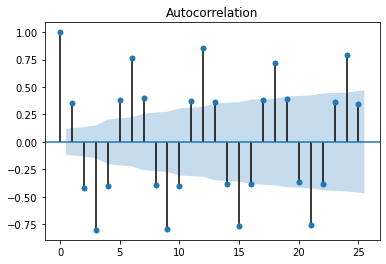

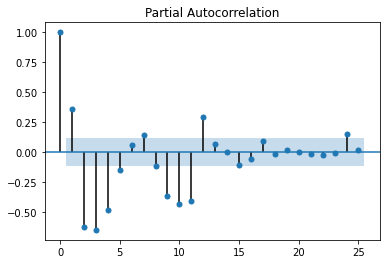

In [22]:
plot_acf(datos['1a diff'].dropna())
plot_pacf(datos['1a diff'].dropna())
plt.show()

# Construcción del modelo SARIMA



In [23]:
train = datos.loc[:'2021-07-01','Producción']
test = datos.loc['2021-07-01':,'Producción']

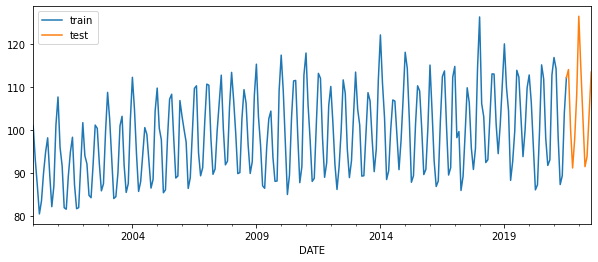

In [24]:
train.plot(label = 'train', figsize =(10,4))
test.plot(label = 'test', figsize =(10,4))
plt.legend()
plt.show()

In [25]:
p =  q = range(0, 2)
p

range(0, 2)

In [26]:
p =  q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [27]:
p = d =  q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

In [28]:
aic_modelos = {}
for parametros in pdq:
  for parametros_s in seasonal_pdq:
      modelo = SARIMAX(datos.loc[:'2021-02-01','Producción'],
                       order = parametros,
                       seasonal_order = parametros_s,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
      results = modelo.fit(method_kwargs={"warn_convergence": False})
      aic_modelos[parametros, parametros_s] = results.aic
      print('ARIMA{} x {} - AIC:{}'.format(parametros, parametros_s, results.aic))  

ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC:1825.9205504866572
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC:1569.5733078844116
ARIMA(0, 1, 0) x (0, 0, 2, 12) - AIC:1422.3262146963011
ARIMA(0, 1, 0) x (0, 1, 0, 12) - AIC:1341.7730484233375
ARIMA(0, 1, 0) x (0, 1, 1, 12) - AIC:1197.8529456518668
ARIMA(0, 1, 0) x (0, 1, 2, 12) - AIC:1137.595168746225
ARIMA(0, 1, 0) x (0, 2, 0, 12) - AIC:1494.8252382312605
ARIMA(0, 1, 0) x (0, 2, 1, 12) - AIC:1251.9949229111612
ARIMA(0, 1, 0) x (0, 2, 2, 12) - AIC:1128.8050906430822
ARIMA(0, 1, 0) x (1, 0, 0, 12) - AIC:1341.152395423696
ARIMA(0, 1, 0) x (1, 0, 1, 12) - AIC:1255.8257559374265
ARIMA(0, 1, 0) x (1, 0, 2, 12) - AIC:1194.5167398963918
ARIMA(0, 1, 0) x (1, 1, 0, 12) - AIC:1263.8979430614493
ARIMA(0, 1, 0) x (1, 1, 1, 12) - AIC:1199.8420783095114
ARIMA(0, 1, 0) x (1, 1, 2, 12) - AIC:1138.044278625459
ARIMA(0, 1, 0) x (1, 2, 0, 12) - AIC:1357.9380647866092
ARIMA(0, 1, 0) x (1, 2, 1, 12) - AIC:1239.823689463362
ARIMA(0, 1, 0) x (1, 2, 2, 12) - AIC:1143.0318723577

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 2) x (2, 0, 1, 12) - AIC:1220.391684931235
ARIMA(0, 1, 2) x (2, 0, 2, 12) - AIC:1131.457125185315
ARIMA(0, 1, 2) x (2, 1, 0, 12) - AIC:1124.6061808393797
ARIMA(0, 1, 2) x (2, 1, 1, 12) - AIC:1088.3602256301238
ARIMA(0, 1, 2) x (2, 1, 2, 12) - AIC:1071.5310823927098
ARIMA(0, 1, 2) x (2, 2, 0, 12) - AIC:1199.4248880303012
ARIMA(0, 1, 2) x (2, 2, 1, 12) - AIC:1110.2030309317856
ARIMA(0, 1, 2) x (2, 2, 2, 12) - AIC:1076.7359584605624
ARIMA(1, 1, 0) x (0, 0, 0, 12) - AIC:1794.7390422873164
ARIMA(1, 1, 0) x (0, 0, 1, 12) - AIC:1560.1157420731465
ARIMA(1, 1, 0) x (0, 0, 2, 12) - AIC:1422.6147239708107
ARIMA(1, 1, 0) x (0, 1, 0, 12) - AIC:1327.2046685441414
ARIMA(1, 1, 0) x (0, 1, 1, 12) - AIC:1182.3920259239494
ARIMA(1, 1, 0) x (0, 1, 2, 12) - AIC:1122.403962686175
ARIMA(1, 1, 0) x (0, 2, 0, 12) - AIC:1481.58302833914
ARIMA(1, 1, 0) x (0, 2, 1, 12) - AIC:1238.398246676316
ARIMA(1, 1, 0) x (0, 2, 2, 12) - AIC:1112.2746445932148
ARIMA(1, 1, 0) x (1, 0, 0, 12) - AIC:1323.765314329658

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 0) x (1, 0, 2, 12) - AIC:1175.1110306966666
ARIMA(1, 1, 0) x (1, 1, 0, 12) - AIC:1244.2679731613835
ARIMA(1, 1, 0) x (1, 1, 1, 12) - AIC:1184.3523922213376
ARIMA(1, 1, 0) x (1, 1, 2, 12) - AIC:1122.7389560884242
ARIMA(1, 1, 0) x (1, 2, 0, 12) - AIC:1341.4728574114301
ARIMA(1, 1, 0) x (1, 2, 1, 12) - AIC:1226.1117042176943
ARIMA(1, 1, 0) x (1, 2, 2, 12) - AIC:1114.270100489362
ARIMA(1, 1, 0) x (2, 0, 0, 12) - AIC:1244.6105809340952
ARIMA(1, 1, 0) x (2, 0, 1, 12) - AIC:1180.5373270416544
ARIMA(1, 1, 0) x (2, 0, 2, 12) - AIC:1172.385111796947
ARIMA(1, 1, 0) x (2, 1, 0, 12) - AIC:1159.867860350509
ARIMA(1, 1, 0) x (2, 1, 1, 12) - AIC:1118.7329916672702
ARIMA(1, 1, 0) x (2, 1, 2, 12) - AIC:1120.3996789560551
ARIMA(1, 1, 0) x (2, 2, 0, 12) - AIC:1231.348434669725
ARIMA(1, 1, 0) x (2, 2, 1, 12) - AIC:1141.3198715821982
ARIMA(1, 1, 0) x (2, 2, 2, 12) - AIC:1124.2011673255568
ARIMA(1, 1, 1) x (0, 0, 0, 12) - AIC:1756.358734755973
ARIMA(1, 1, 1) x (0, 0, 1, 12) - AIC:1505.71033784650

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 2) x (1, 1, 1, 12) - AIC:1137.3915443907335
ARIMA(1, 1, 2) x (1, 1, 2, 12) - AIC:1077.2414158892834
ARIMA(1, 1, 2) x (1, 2, 0, 12) - AIC:1304.1362189900242
ARIMA(1, 1, 2) x (1, 2, 1, 12) - AIC:1178.1776280215333
ARIMA(1, 1, 2) x (1, 2, 2, 12) - AIC:1072.185677236809
ARIMA(1, 1, 2) x (2, 0, 0, 12) - AIC:1205.0577984666634


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 2) x (2, 0, 1, 12) - AIC:1151.7368492066203


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 2) x (2, 0, 2, 12) - AIC:1130.2144323778914
ARIMA(1, 1, 2) x (2, 1, 0, 12) - AIC:1118.1558283664694
ARIMA(1, 1, 2) x (2, 1, 1, 12) - AIC:1082.9551865930343
ARIMA(1, 1, 2) x (2, 1, 2, 12) - AIC:1070.741999994089
ARIMA(1, 1, 2) x (2, 2, 0, 12) - AIC:1190.6776482378577
ARIMA(1, 1, 2) x (2, 2, 1, 12) - AIC:1103.7307055538574
ARIMA(1, 1, 2) x (2, 2, 2, 12) - AIC:1077.1010897683811
ARIMA(2, 1, 0) x (0, 0, 0, 12) - AIC:1664.3654510158237
ARIMA(2, 1, 0) x (0, 0, 1, 12) - AIC:1504.8758054357627
ARIMA(2, 1, 0) x (0, 0, 2, 12) - AIC:1388.0047370380098
ARIMA(2, 1, 0) x (0, 1, 0, 12) - AIC:1304.4885986873292
ARIMA(2, 1, 0) x (0, 1, 1, 12) - AIC:1172.3199883479592
ARIMA(2, 1, 0) x (0, 1, 2, 12) - AIC:1110.2488074305124
ARIMA(2, 1, 0) x (0, 2, 0, 12) - AIC:1451.859697028328
ARIMA(2, 1, 0) x (0, 2, 1, 12) - AIC:1219.5380552691113
ARIMA(2, 1, 0) x (0, 2, 2, 12) - AIC:1103.1145024458938
ARIMA(2, 1, 0) x (1, 0, 0, 12) - AIC:1302.0991202893392
ARIMA(2, 1, 0) x (1, 0, 1, 12) - AIC:1222.21351265

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 1) x (1, 2, 2, 12) - AIC:1077.2691937414086
ARIMA(2, 1, 1) x (2, 0, 0, 12) - AIC:1200.1233088780623
ARIMA(2, 1, 1) x (2, 0, 1, 12) - AIC:1146.519122499502


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 1) x (2, 0, 2, 12) - AIC:1133.9075039867926
ARIMA(2, 1, 1) x (2, 1, 0, 12) - AIC:1111.7335461429952
ARIMA(2, 1, 1) x (2, 1, 1, 12) - AIC:1075.4306868569015
ARIMA(2, 1, 1) x (2, 1, 2, 12) - AIC:1077.34936636413
ARIMA(2, 1, 1) x (2, 2, 0, 12) - AIC:1185.5965067895345
ARIMA(2, 1, 1) x (2, 2, 1, 12) - AIC:1098.537336876727
ARIMA(2, 1, 1) x (2, 2, 2, 12) - AIC:1083.9556850085885
ARIMA(2, 1, 2) x (0, 0, 0, 12) - AIC:1407.6876103103236
ARIMA(2, 1, 2) x (0, 0, 1, 12) - AIC:1290.894887071659


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 2) x (0, 0, 2, 12) - AIC:1225.9290473515762
ARIMA(2, 1, 2) x (0, 1, 0, 12) - AIC:1278.4134172516751
ARIMA(2, 1, 2) x (0, 1, 1, 12) - AIC:1137.1686902678844
ARIMA(2, 1, 2) x (0, 1, 2, 12) - AIC:1080.7301564504887
ARIMA(2, 1, 2) x (0, 2, 0, 12) - AIC:1422.8567929503156
ARIMA(2, 1, 2) x (0, 2, 1, 12) - AIC:1187.4217010049322
ARIMA(2, 1, 2) x (0, 2, 2, 12) - AIC:1072.2940220131868
ARIMA(2, 1, 2) x (1, 0, 0, 12) - AIC:1275.8655197457786
ARIMA(2, 1, 2) x (1, 0, 1, 12) - AIC:1196.0755505980865


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 2) x (1, 0, 2, 12) - AIC:1137.7175556740858
ARIMA(2, 1, 2) x (1, 1, 0, 12) - AIC:1202.849090397433
ARIMA(2, 1, 2) x (1, 1, 1, 12) - AIC:1139.7953483677202
ARIMA(2, 1, 2) x (1, 1, 2, 12) - AIC:1079.1726464751605
ARIMA(2, 1, 2) x (1, 2, 0, 12) - AIC:1294.6185853438228
ARIMA(2, 1, 2) x (1, 2, 1, 12) - AIC:1179.978647275991


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 2) x (1, 2, 2, 12) - AIC:1074.7610218416203
ARIMA(2, 1, 2) x (2, 0, 0, 12) - AIC:1202.0817832018226


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 2) x (2, 0, 1, 12) - AIC:1148.5171970825688


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 2) x (2, 0, 2, 12) - AIC:1132.2650810379478
ARIMA(2, 1, 2) x (2, 1, 0, 12) - AIC:1113.5102721114577
ARIMA(2, 1, 2) x (2, 1, 1, 12) - AIC:1077.452304839901
ARIMA(2, 1, 2) x (2, 1, 2, 12) - AIC:1072.699713325725
ARIMA(2, 1, 2) x (2, 2, 0, 12) - AIC:1187.12942712937
ARIMA(2, 1, 2) x (2, 2, 1, 12) - AIC:1100.3346311475523
ARIMA(2, 1, 2) x (2, 2, 2, 12) - AIC:1078.8003320721132


El criterio de información de Akaike ([AIC](https://es.wikipedia.org/wiki/Criterio_de_informaci%C3%B3n_de_Akaike)) es una medida de la calidad relativa de un modelo estadístico, para un conjunto dado de datos.

Considera la bondad de ajuste del modelo a los datos, pero también la complejidad del modelo (número de parámetros)

AIC ofrece una estimación relativa de la información perdida cuando se utiliza un modelo determinado para representar el proceso que genera los datos

In [29]:
print('Modelo: ', min(aic_modelos, key = aic_modelos.get))
print('AIC: ',min(aic_modelos.values()))


Modelo:  ((1, 1, 2), (0, 2, 2, 12))
AIC:  1070.1793268240283


In [30]:
modelo = SARIMAX(datos['Producción'],
                       order = (1,1,2),
                       seasonal_order = (0,2,2,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False)
resultados = modelo.fit()
print(resultados.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5394      0.208      2.598      0.009       0.132       0.946
ma.L1         -1.1200      0.232     -4.826      0.000      -1.575      -0.665
ma.L2          0.1688      0.197      0.857      0.392      -0.217       0.555
ma.S.L12      -1.9789    295.185     -0.007      0.995    -580.532     576.574
ma.S.L24       1.0001    298.363      0.003      0.997    -583.781     585.781
sigma2         7.8622   2345.636      0.003      0.997   -4589.500    4605.224


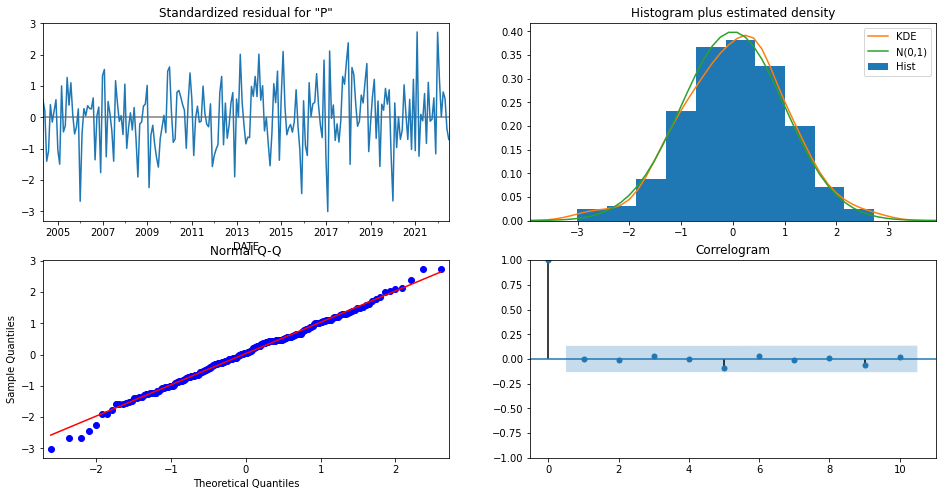

In [31]:
resultados.plot_diagnostics(figsize = (16,8))
plt.show()

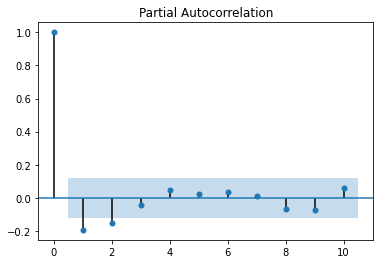

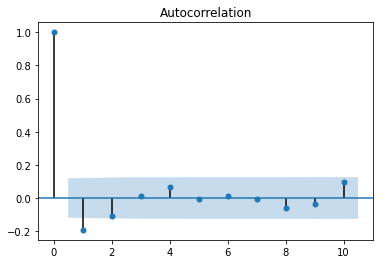

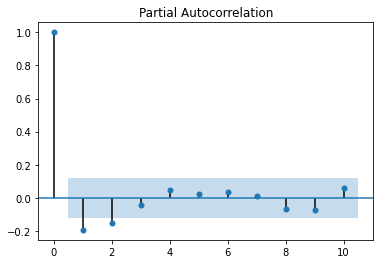

In [33]:
resultados.resid
plot_acf(resultados.resid, lags=10)
plot_pacf(resultados.resid, lags=10)

# Validación

In [34]:
pred = resultados.get_prediction(start=pd.to_datetime('2021-02-01'),
                                 end=pd.to_datetime('2022-06-01'),)
pred.predicted_mean

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


DATE
2021-02-01    106.227425
2021-03-01    102.145599
2021-04-01     87.007215
2021-05-01     89.680746
2021-06-01    101.751000
2021-07-01    114.652407
2021-08-01    110.803405
2021-09-01    100.725263
2021-10-01     91.336454
2021-11-01     96.018120
2021-12-01    111.785217
2022-01-01    118.534073
2022-02-01    110.791625
2022-03-01    102.722911
2022-04-01     89.074037
2022-05-01     92.107107
2022-06-01    104.798369
Freq: MS, Name: predicted_mean, dtype: float64

In [35]:
#intervalo de confianza
pred_IC = pred.conf_int()
pred_IC

,lower Producción,upper Producción
DATE,,
2021-02-01,100.438981,112.015869
2021-03-01,96.374753,107.916444
2021-04-01,81.236460,92.777969
2021-05-01,83.911074,95.450419
2021-06-01,95.982561,107.519439
2021-07-01,108.885102,120.419712
2021-08-01,105.037106,116.569703
2021-09-01,94.959852,106.490675
2021-10-01,85.571823,97.101085


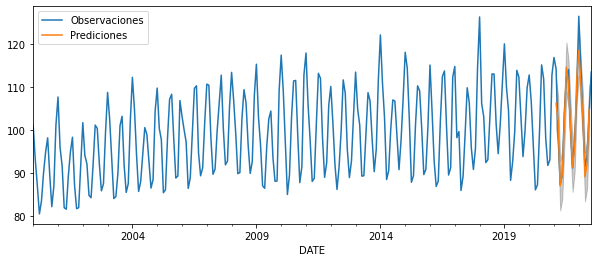

In [37]:
fig = datos.loc[:,'Producción'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

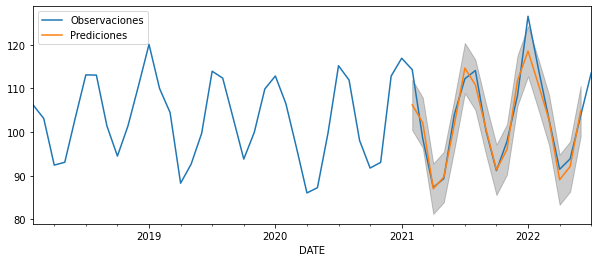

In [36]:
fig = datos.loc['2018-02-01':,'Producción'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

In [38]:
y_pred  = pred.predicted_mean
y_real = datos.loc['2021-02-01':'2022-02-01','Producción']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 14.77
La raiz del error cuadrático medio es 3.84
